In [11]:
import json
from scipy.sparse import load_npz,save_npz,diags,csr_matrix,issparse
from matplotlib.patches import Wedge, Patch
import numpy as np
import networkx as nx
import pickle
from matplotlib import pyplot as plt

In [3]:
DISEASE = "BIPOLAR"
DISEASE_FOLDER = f"../output/{DISEASE}/"
RESULT_FOLDER = DISEASE_FOLDER + "leiden_results"
DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{DISEASE}/"
MSIGDB_DIRECTORY = "../../Gen_Hypergraph/output/MSigDB_Full/"

with open(DISEASE_FOLDER + "gene_to_index_distinct.json", "r") as file:
    gene_to_index_distinct = json.load(file)
    
try:
    with open(DGIDB_DIRECTORY + f"gene_to_index_{DISEASE}.json", "r") as file:
        DGIDB_gene_to_index = json.load(file)
except FileNotFoundError:
    DGIDB_gene_to_index = {}
    print("File not found. Setting DGIDB_gene_to_index to be {}.")
    
    
sim_mat = load_npz(f"{DISEASE_FOLDER}/agg_sim_mat.npz")

File not found. Setting DGIDB_gene_to_index to be {}.


In [4]:
# Loading result graph and communities
with open(f"{RESULT_FOLDER}/result_communities.pkl", "rb") as f:
    communities = pickle.load(f)
with open(f"{RESULT_FOLDER}/result_communities_selected.pkl", "rb") as f:
    communities_selected = pickle.load(f)
with open(f"{RESULT_FOLDER}/result_graph.pkl", "rb") as f:
    graph = pickle.load(f)

In [27]:
def community_similarity_matrix(G, communities, normalize=True):
    """
    Compute community–community similarity as specified by PI:
        sim[i, j] = (sum of edge weights between members of communities i and j)
                    / (|Ci| * |Cj|)

    Then:
      - diagonal is forced to 0
      - matrix is normalized so that max(sim) = 1 (if normalize=True)
    """
    n = len(communities)
    sim = np.zeros((n, n), dtype=float)

    # ----- compute similarities -----
    for i in range(n):
        A = communities[i]
        sizeA = len(A)
        for j in range(i + 1, n):
            B = communities[j]
            sizeB = len(B)

            total_weight = 0.0
            for u in A:
                for v in B:
                    if G.has_edge(u, v):
                        total_weight += G[u][v].get("weight", 1.0)

            value = total_weight / (sizeA * sizeB)
            sim[i, j] = value
            sim[j, i] = value

    # ----- set diagonal to zero -----
    np.fill_diagonal(sim, 0.0)

    # ----- normalization -----
    if normalize:
        max_val = sim.max()
        if max_val > 0:
            sim = sim / max_val
        # if max_val == 0 → leave as all zeros

    return sim


In [28]:
comm_sim_mat = community_similarity_matrix(graph, communities_selected)

In [29]:
comm_sim_mat

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.33128019e-01,
        4.05677770e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.31535650e-01, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 3.05648717e-01,
        0.00000000e+00, 0.00000000e+00, 4.58615809e-02, 3.20694238e-02,
        4.16938387e-01, 2.65113875e-93],
       [0.00000000e+00, 5.31535650e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.10358291e-01, 0.00000000e+00,
        8.41903685e-02, 0.00000000e+00],
       [4.33128019e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.000

In [25]:
def build_community_graph_from_similarity(sim_matrix, threshold=0.0):
    """
    Each community = one node.
    Edge weight between community i and j = sim_matrix[i, j].

    Parameters
    ----------
    sim_matrix : (n, n) array-like
        Community–community similarity matrix.
    threshold : float
        Only edges with weight > threshold are kept.

    Returns
    -------
    G : networkx.Graph
        Graph with nodes 0..n-1, edge attribute 'weight'.
    """
    sim = np.asarray(sim_matrix)
    n = sim.shape[0]

    G = nx.Graph()
    G.add_nodes_from(range(n))  # nodes = community indices

    for i in range(n):
        for j in range(i + 1, n):
            w = sim[i, j]
            if w > threshold:
                G.add_edge(i, j, weight=float(w))

    return G


def plot_community_graph_circular(G, community_sizes=None,
                                  figsize=(7, 7),
                                  edge_label_digits=2):
    """
    Plot a community graph using a circular layout.
    """
    # Circular positions
    pos = nx.circular_layout(G)

    # Node sizes
    if community_sizes is None:
        node_sizes = 500
    else:
        cs = np.asarray(community_sizes, dtype=float)
        if cs.max() > 0:
            node_sizes = 300 + 1500 * (cs / cs.max())
        else:
            node_sizes = 500

    # Edge widths
    edge_weights = nx.get_edge_attributes(G, "weight")
    widths = [4 * w for w in edge_weights.values()]  # thickness proportional

    plt.figure(figsize=figsize)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Edge labels (optional but helpful)
    edge_labels = {e: f"{w:.{edge_label_digits}f}" for e, w in edge_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

    plt.title("Community Similarity Graph (Circular Layout)", fontsize=14)
    plt.axis("off")
    plt.show()



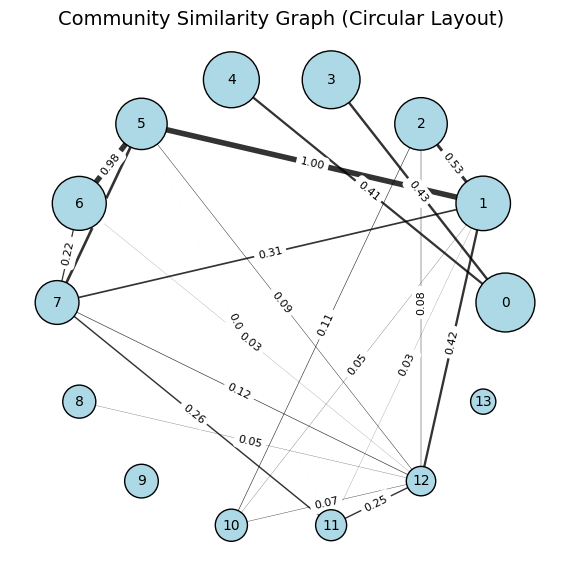

In [30]:
sizes = [len(c) for c in communities_selected]

G_comm = build_community_graph_from_similarity(comm_sim_mat, threshold=1e-4)
plot_community_graph_circular(G_comm, community_sizes=sizes)

# below is not tested

In [12]:
def plot_community_similarity_pies(
    sim_matrix,
    community_category_counts,
    community_sizes=None,
    min_frac=0.05,
    edge_threshold=0.0,
    figsize=(10, 8),
    title="Community similarity (pie = category composition)",
    edge_label_fmt="{:.2f}",
    layout="spring",
    seed=42,
):
    """
    Plot a community–community similarity graph where each node is drawn
    as a pie chart showing that community's category composition.

    Parameters
    ----------
    sim_matrix : array-like or (n,n) sparse matrix
        Community–community similarity matrix. Can be dense (NumPy array)
        or sparse (CSR). Assumed symmetric, non-negative.
        Entry (i,j) gives similarity between community i and j.

    community_category_counts : list of dict
        Length = n_communities.
        community_category_counts[i] is a dict:
            {category_name: count, ...}
        This is where you can already union Reactome/KEGG/GO, e.g.
            merged_dict[i] = (
                reactome_category_counts_and_overlap_score[i]
                | kegg_category_counts_and_overlap_score[i]
                | go_category_counts_and_overlap_score[i]
            )
        Only the *counts* are used here.

    community_sizes : 1D array-like or None
        Size of each community, used for node radius.
        If None, size is inferred as sum of counts in
        community_category_counts[i].

    min_frac : float, default 0.05
        Per-community threshold: categories whose count / total_count
        is < min_frac are lumped into an "Other" slice.

    edge_threshold : float, default 0.0
        Only draw edges with similarity > edge_threshold.

    figsize : tuple
        Matplotlib figure size.

    title : str
        Suptitle for the plot.

    edge_label_fmt : str
        Format string for edge label text.

    layout : {"spring", "kamada_kawai"}
        Which NetworkX layout to use.

    seed : int
        Random seed for reproducible layouts.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """

    # ------------------------------------------------------------------
    # 0. Basic checks & normalization
    # ------------------------------------------------------------------
    if issparse(sim_matrix):
        A = sim_matrix.tocsr()
        n = A.shape[0]
        sim_dense = A.toarray()
    else:
        sim_dense = np.asarray(sim_matrix)
        n = sim_dense.shape[0]

    if len(community_category_counts) != n:
        raise ValueError(
            f"community_category_counts has length {len(community_category_counts)}, "
            f"but sim_matrix is {n}x{n}."
        )

    if community_sizes is None:
        community_sizes = np.array(
            [sum(cat_dict.values()) for cat_dict in community_category_counts],
            dtype=float,
        )
    else:
        community_sizes = np.asarray(community_sizes, dtype=float)
        if community_sizes.shape[0] != n:
            raise ValueError("community_sizes must have length n_communities")

    # Avoid zeros in size (for radius scaling)
    community_sizes = np.maximum(community_sizes, 1.0)

    # ------------------------------------------------------------------
    # 1. Build the similarity graph
    # ------------------------------------------------------------------
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)

    for i in range(n):
        for j in range(i + 1, n):
            w = sim_dense[i, j]
            if w > edge_threshold:
                G.add_edge(i, j, weight=w)

    # ------------------------------------------------------------------
    # 2. Layout
    # ------------------------------------------------------------------
    if layout == "spring":
        pos = nx.spring_layout(G, seed=seed, weight="weight")
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, weight="weight")
    else:
        raise ValueError("layout must be 'spring' or 'kamada_kawai'")

    # ------------------------------------------------------------------
    # 3. Prepare category universe and hatching patterns
    # ------------------------------------------------------------------
    # Collect all category names (for consistent legend & hatches)
    all_categories = set()
    for d in community_category_counts:
        all_categories.update(d.keys())
    all_categories = sorted(all_categories)

    # Hatching patterns to distinguish categories (repeats if needed)
    hatch_patterns = [
        "/", "\\", "|", "-", "+", "x", "o", "O", ".", "*",
        "///", "\\\\", "||", "--", "++", "xx", "oo", "OO"
    ]
    num_patterns = len(hatch_patterns)

    category_to_hatch = {
        cat: hatch_patterns[i % num_patterns] for i, cat in enumerate(all_categories)
    }

    # ------------------------------------------------------------------
    # 4. Start plotting
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw edges first (behind nodes)
    if G.number_of_edges() > 0:
        weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
        # Normalize line widths nicely
        if weights.max() > 0:
            widths = 1.0 + 4.0 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-12)
        else:
            widths = np.ones_like(weights)
        nx.draw_networkx_edges(G, pos, ax=ax, width=widths, alpha=0.4)

        # Edge labels
        edge_labels = {
            (u, v): edge_label_fmt.format(d["weight"])
            for u, v, d in G.edges(data=True)
        }
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=edge_labels, font_size=8, ax=ax
        )

    # ------------------------------------------------------------------
    # 5. Node pies
    # ------------------------------------------------------------------
    # radius scaling: make radii between r_min and r_max
    r_min, r_max = 0.15, 0.35
    size_norm = (community_sizes - community_sizes.min()) / (
        community_sizes.max() - community_sizes.min() + 1e-12
    )
    radii = r_min + (r_max - r_min) * size_norm

    # Legend accumulation: which categories actually appear after thresholding?
    legend_categories = set()

    for i in range(n):
        x, y = pos[i]
        r = radii[i]
        cat_counts = community_category_counts[i]

        if not cat_counts:
            # no categories; draw a simple grey circle
            circ = plt.Circle((x, y), r, facecolor="lightgrey", edgecolor="black", alpha=0.7)
            ax.add_patch(circ)
            continue

        total = sum(cat_counts.values())
        if total <= 0:
            circ = plt.Circle((x, y), r, facecolor="lightgrey", edgecolor="black", alpha=0.7)
            ax.add_patch(circ)
            continue

        # Filter categories by min_frac and collect "Other"
        cat_items = sorted(cat_counts.items(), key=lambda kv: kv[1], reverse=True)
        kept = []
        other_count = 0
        for cat, cnt in cat_items:
            frac = cnt / total
            if frac >= min_frac:
                kept.append((cat, cnt))
            else:
                other_count += cnt

        if other_count > 0:
            kept.append(("Other", other_count))

        kept_total = sum(cnt for _, cnt in kept)

        # Draw wedges
        start_angle = 0.0
        for cat, cnt in kept:
            frac = cnt / kept_total
            theta = 360.0 * frac
            wedge = Wedge(
                center=(x, y),
                r=r,
                theta1=start_angle,
                theta2=start_angle + theta,
                facecolor="lightgrey",   # uniform color
                edgecolor="black",
                linewidth=0.7,
                hatch=category_to_hatch.get(cat, "///") if cat != "Other" else "",
                alpha=0.9,
            )
            ax.add_patch(wedge)
            start_angle += theta

            if cat != "Other":
                legend_categories.add(cat)

    # ------------------------------------------------------------------
    # 6. Legend on the right
    # ------------------------------------------------------------------
    legend_handles = []
    legend_labels = []

    for cat in sorted(legend_categories):
        hatch = category_to_hatch[cat]
        patch = Patch(
            facecolor="lightgrey",
            edgecolor="black",
            hatch=hatch,
            label=cat,
        )
        legend_handles.append(patch)
        legend_labels.append(cat)

    if legend_handles:
        ax.legend(
            handles=legend_handles,
            labels=legend_labels,
            title="Categories",
            bbox_to_anchor=(1.05, 0.5),
            loc="center left",
            borderaxespad=0.0,
        )

    ax.set_title(title)
    plt.tight_layout()
    return fig, ax
